In [ ]:
!pip install transformers trl datasets peft accelerate bitsandbytes sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.3/155.3 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.6/536.6 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.4/183.4 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.0/105.0 MB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.3/38.3 MB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.7 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 10.0.1
    Uninstalling pyarrow-10.0.1:
      Successfully uninstalled pyarrow-10.0.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are inst

In [ ]:
import os
import gc
from datasets import load_dataset
import torch
import torch.nn as nn
import bitsandbytes as bnb
import transformers
from transformers import AutoTokenizer, AutoConfig, AutoModelForCausalLM, TrainingArguments,BitsAndBytesConfig
from peft import LoraConfig, PeftModel, get_peft_config
from trl import SFTTrainer

## Load PubMed QA data

In [ ]:
data = load_dataset("pubmed_qa","pqa_labeled")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [ ]:
data

DatasetDict({
    train: Dataset({
        features: ['pubid', 'question', 'context', 'long_answer', 'final_decision'],
        num_rows: 1000
    })
})

In [ ]:
data['train']['question'][0]

'Do mitochondria play a role in remodelling lace plant leaves during programmed cell death?'

In [ ]:
data['train']['long_answer'][0]

'Results depicted mitochondrial dynamics in vivo as PCD progresses within the lace plant, and highlight the correlation of this organelle with other organelles during developmental PCD. To the best of our knowledge, this is the first report of mitochondria and chloroplasts moving on transvacuolar strands to form a ring structure surrounding the nucleus during developmental PCD. Also, for the first time, we have shown the feasibility for the use of CsA in a whole plant system. Overall, our findings implicate the mitochondria as playing a critical and early role in developmentally regulated PCD in the lace plant.'

In [ ]:
data['train']['context'][0]

{'contexts': ['Programmed cell death (PCD) is the regulated death of cells within an organism. The lace plant (Aponogeton madagascariensis) produces perforations in its leaves through PCD. The leaves of the plant consist of a latticework of longitudinal and transverse veins enclosing areoles. PCD occurs in the cells at the center of these areoles and progresses outwards, stopping approximately five cells from the vasculature. The role of mitochondria during PCD has been recognized in animals; however, it has been less studied during PCD in plants.',
  'The following paper elucidates the role of mitochondrial dynamics during developmentally regulated PCD in vivo in A. madagascariensis. A single areole within a window stage leaf (PCD is occurring) was divided into three areas based on the progression of PCD; cells that will not undergo PCD (NPCD), cells in early stages of PCD (EPCD), and cells in late stages of PCD (LPCD). Window stage leaves were stained with the mitochondrial dye MitoT

In [ ]:
#hyperparameters
LORA_ALPHA = 32
LORA_DROPOUT = 0.2
LORA_R = 4

LEARNING_RATE = 2e-4
NUM_EPOCHS = 1
BATCH_SIZE = 1
WEIGHT_DECAY = 0.001
MAX_GRAD_NORM = 0.3
gradient_accumulation_steps = 16
STEPS = 1
OPTIM = "adam"
MAX_STEPS = 512
OUTPUT_DIR = "./results"

## Quantization configuration using Bitsandbytes

In [ ]:
bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_use_double_quant=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.bfloat16
    )
torch.cuda.get_device_capability()
device_map = "cuda:0"

## Define model and tokenization

In [ ]:
model_name = "nousresearch/llama-2-7b-chat-hf"

In [ ]:
model = AutoModelForCausalLM.from_pretrained(
            model_name,
            quantization_config=bnb_config,
            device_map=device_map,
        )
model.config.pretraining_tp = 1

config.json:   0%|          | 0.00/583 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/179 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:381: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:386: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(


In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True,use_fast=False)
tokenizer.pad_token = tokenizer.eos_token

tokenizer_config.json:   0%|          | 0.00/746 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/21.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/435 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

In [ ]:
torch.cuda.empty_cache()

## Define LoRA adapter

In [ ]:
peft_config = LoraConfig(
      lora_alpha= LORA_ALPHA,
      lora_dropout= LORA_DROPOUT,
      r= LORA_R,
      bias="none",
      task_type="CAUSAL_LM",
  )

## Setup training parameters

In [ ]:
training_args = TrainingArguments(
      output_dir= OUTPUT_DIR,
      per_device_train_batch_size=BATCH_SIZE,
      gradient_accumulation_steps= gradient_accumulation_steps,
      learning_rate= LEARNING_RATE,
      logging_steps= STEPS,
      num_train_epochs= NUM_EPOCHS,
      max_steps= MAX_STEPS,
)

In [ ]:
torch.cuda.empty_cache()

In [ ]:
trainer = SFTTrainer(
        model=model,
        train_dataset=data['train'],
        peft_config=peft_config,
        dataset_text_field= "question",
        max_seq_length=512,
        tokenizer=tokenizer,
        args=training_args,
)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/torch/profiler/profiler.py:339: UserWarning: Profiler won't be using warmup, this can skew profiler results
  warn("Profiler won't be using warmup, this can skew profiler results")


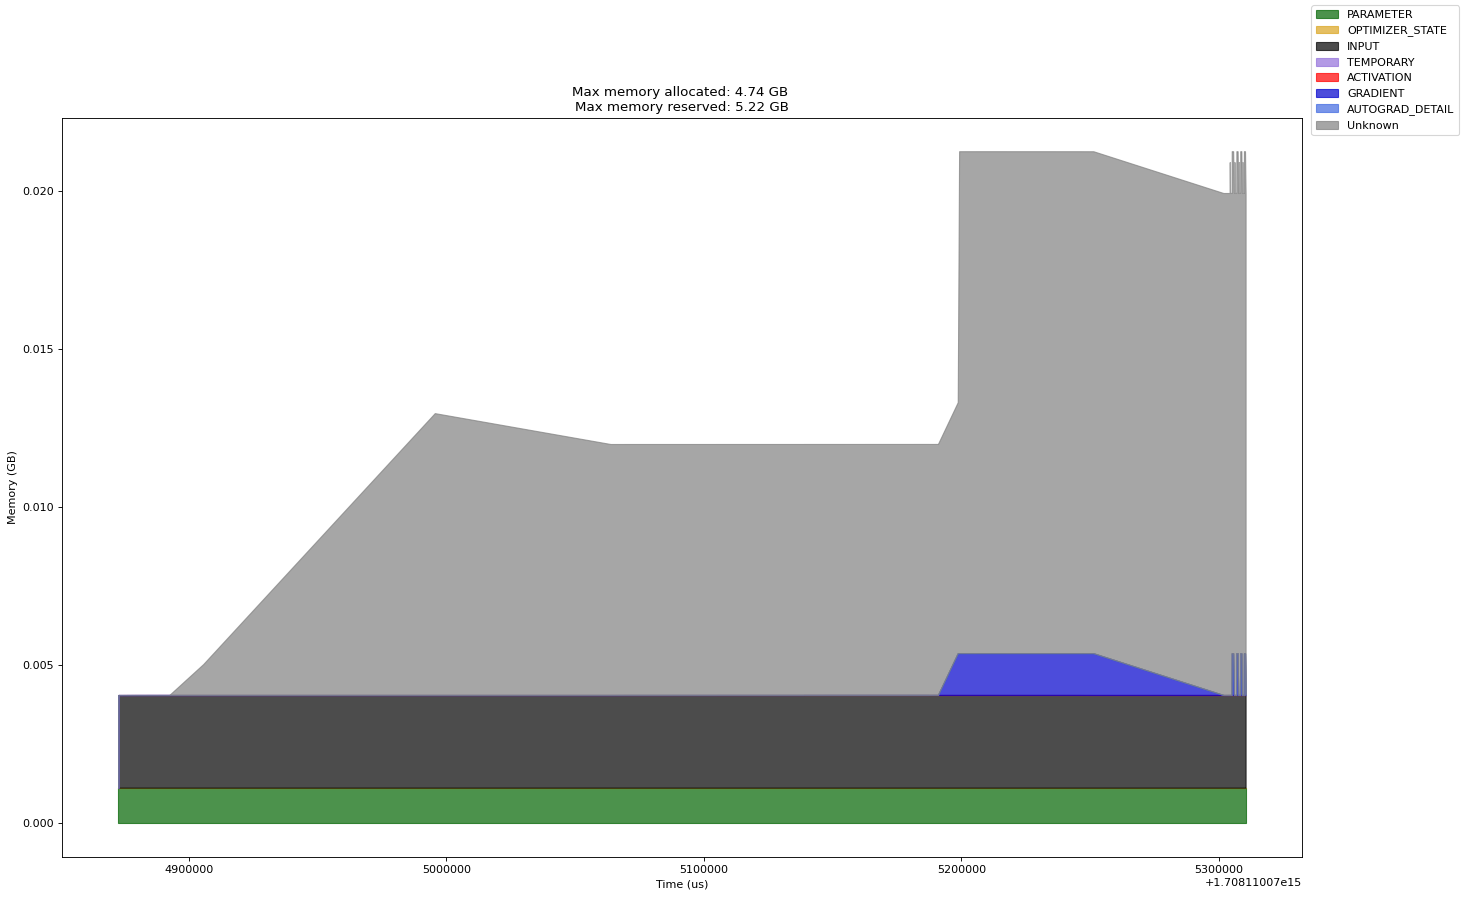

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define a simple model, loss function, and optimizer
class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.fc = nn.Linear(3 * 224 * 224, 2)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.fc(x)

# Assuming you have a model, loss function, and optimizer defined somewhere
model = SimpleModel().cuda()  # Move the model to the GPU
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Define the trace handler function
def trace_handler(prof):
    # Save the trace to a file
    prof.export_chrome_trace("trace.json")

# Initialize the profiler context
with torch.profiler.profile(
    activities=[torch.profiler.ProfilerActivity.CPU, torch.profiler.ProfilerActivity.CUDA],
    schedule=torch.profiler.schedule(wait=0, warmup=0, active=6, repeat=1),
    record_shapes=True,
    profile_memory=True,
    with_stack=True,
    on_trace_ready=trace_handler,
) as prof:
    # Dummy data for illustration purposes
    original_batch_size = 10
    new_batch_size = 5  # Adjust based on available GPU memory
    inputs = torch.randn((new_batch_size, 3, 224, 224)).cuda().float()  # Change data type to Float
    labels = torch.randint(0, 2, (new_batch_size,)).cuda()

    # Run the PyTorch Model inside the profile context
    for _ in range(5):
        prof.step()
        with torch.profiler.record_function("## forward ##"):
            pred = model(inputs)

        with torch.profiler.record_function("## backward ##"):
            loss_fn(pred, labels).backward()

        with torch.profiler.record_function("## optimizer ##"):
            optimizer.step()
            optimizer.zero_grad(set_to_none=True)

        torch.cuda.empty_cache()  # Free up GPU memory

# Construct the memory timeline HTML plot
prof.export_memory_timeline("timeline.html", device="cuda:0")


In [ ]:
trainer.train()

Step,Training Loss
1,3.128700
2,3.029400
3,3.404800
4,3.562600
5,3.303100
6,2.811700
7,3.018300
8,3.098900
9,2.812000
10,2.824500


In [ ]:
logging.set_verbosity(logging.CRITICAL)
torch.cuda.empty_cache()

In [ ]:
model_to_save = trainer.model.module if hasattr(trainer.model, 'module') else trainer.model # Take care of distributed/parallel training
model_to_save.save_pretrained("outputs")

## Test the model

### Using Inference pipeline

In [ ]:
pipe = pipeline(task="text-generation",model=model,tokenizer=tokenizer,max_length=500)

In [ ]:
prompt = "Who is at risk for Prostate Cancer?"

In [ ]:
template = f"""<s>[INST] <<SYS>>
You are a honest Medical assistant bot.
Your answers should not include any harmful, unethical, racist, sexist, toxic, dangerous, or illegal content.
Please ensure that your responses are socially unbiased and positive in nature.
If a question does not make any sense, or is not factually coherent, explain why instead of answering something not correct.
If you don't know the answer to a question, please don't share false information.
<</SYS>>

{prompt} [/INST]
"""

In [ ]:
result = pipe(template)

In [ ]:
response = result[0]['generated_text']
index = response.find("[/INST]")+len("[/INST]")

In [ ]:
print(response[index:].strip())

## Without using pipeline

In [ ]:
from peft import get_peft_model

In [ ]:
lora_config = LoraConfig.from_pretrained('outputs')
model = get_peft_model(model, lora_config)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

In [ ]:
inputs = tokenizer(template, return_tensors="pt").to(device)
model = model.to(device)
outputs = model.generate(**inputs, max_new_tokens=1024)
print(tokenizer.decode(outputs[0], skip_special_tokens=True))

In [ ]:
!nvidia-smi -L

In [ ]:
import streamlit as st
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

# Load the fine-tuned model and tokenizer
model_name = "your_model_name"
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Function to generate a response
def generate_response(input_text):
    inputs = tokenizer(input_text, return_tensors="pt")
    outputs = model.generate(**inputs, max_length=100, num_beams=5, early_stopping=True)
    response = tokenizer.decode(outputs[0])
    return response

# Streamlit App
st.title("Fine-Tuned Llama Model")
input_text = st.text_input("Enter your text:", "Type here...")

if st.button("Generate Response"):
    if input_text:
        response = generate_response(input_text)
        st.write(response)
    else:
        st.write("Please enter text for generation.")